# Ex. 2.3
# Perform SVD to reduce dimension of dataset and build NN in subspace so to perform future state forecasting

We import usefull libraries

In [1]:
import numpy as np
from numpy.random import default_rng
from numpy.fft import fft, ifft, fftfreq
import matplotlib.pyplot as plt
import scipy.io as sio
import tensorflow as tf
import tensorflow.keras as tfk
import tensorflow.keras.layers as tfkl
from matplotlib.animation import FuncAnimation
np.random.seed(11467634)

We load solution of reaction-diffusion equation previously generated

In [2]:
data = sio.loadmat('../input/reactiondiffudion/reaction_diffusion_big.mat')

The u and v variables solved are in a 512x512 matrix and 201 timesteps are considered

Therefore the dimensionality of the dataset is very large 512x512x2 for each timestep

In [3]:
u = data['u']
v = data['v']
x = data['x']
y = data['y']
t = data['t']
#u_input = u[0:-1,:]
#u_output = u[1:,:]
dt = t[1]-t[0]
dx = x[0,1]-x[0,0]

n = len(x)
m = len(t)

Plot of solutions at last timestep

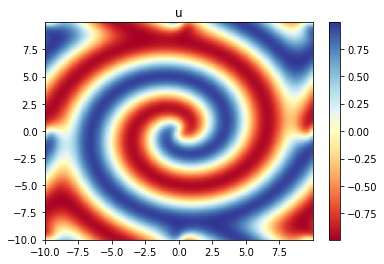

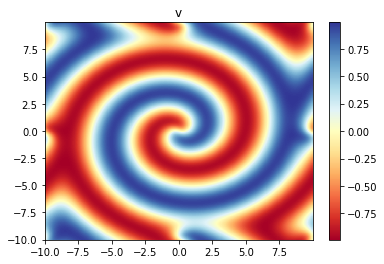

In [4]:
fig, ax = plt.subplots(1,1)
X, Y = np.meshgrid(x, y)
im = ax.pcolormesh(X, Y, u[:,:,-1], cmap='RdYlBu', rasterized=True)
fig.colorbar(im)
plt.title('u')
plt.show()
fig, ax = plt.subplots(1,1)
X, Y = np.meshgrid(x, y)
im = ax.pcolormesh(X, Y, v[:,:,-1], cmap='RdYlBu', rasterized=True)
fig.colorbar(im)
plt.title('v')
plt.show()

To perform SVD we need to vectorize the input matrixes

Each timestep of u and v is vectorized then a new vector z is built concatenating the vectorized u and v

In [5]:
n_elem = u.shape[0]*u.shape[1]
u_lin = u.reshape([n_elem,t.shape[0]])
v_lin = v.reshape([n_elem,t.shape[0]])
print('Once u is vectorized it has the shape',np.shape(u_lin))
z = np.zeros([n_elem*2,t.shape[0]])
z = np.concatenate((u_lin,v_lin), axis=0)
print('The shape of the vector z is', np.shape(z))

Once u is vectorized it has the shape (262144, 201)
The shape of the vector z is (524288, 201)


Now we perform the reduced SVD of z

In [6]:
U,S,VT = np.linalg.svd(z,full_matrices = False)

In order to understand how many modes to keep for the dimensionality reduction we evaluate the cumulative energy of the modes

We keep the modes that maintain at least 99% of the original system characteristics

We also evaluate the values of S

Order of truncation: 12


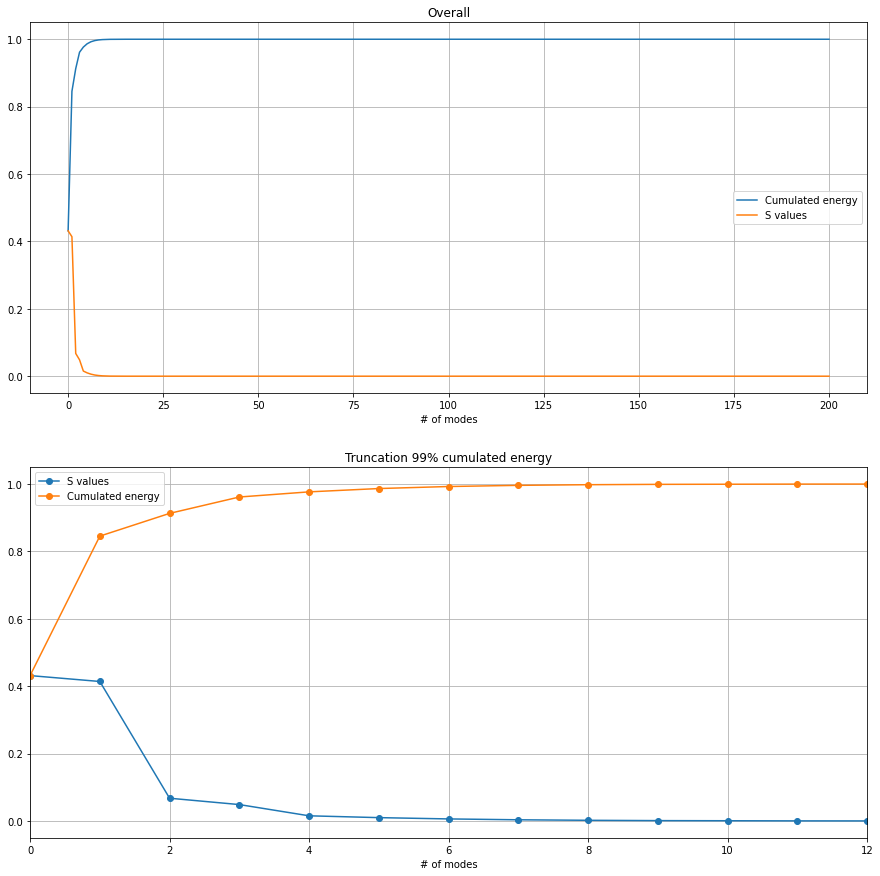

In [7]:
s_values = S/np.sum(S)
cdS = np.cumsum(S)/np.sum(S)
r_99 = np.max(np.where(S>0.99))

print('Order of truncation:', r_99)
fig, 
plt.figure(figsize=(15,15))
plt.subplot(2,1,1)
plt.plot(cdS,label='Cumulated energy')
plt.plot(s_values,label='S values')
plt.xlabel('# of modes')
plt.title('Overall')
plt.legend()
plt.grid()

plt.subplot(2,1,2)
plt.plot(s_values,'-o',label='S values')
plt.xlabel('# of modes')
plt.plot(cdS,'-o',label='Cumulated energy')
plt.xlim([0,r_99])
plt.title('Truncation 99% cumulated energy')
plt.grid()
plt.legend()
plt.show()



The first r_99 modes are plotted

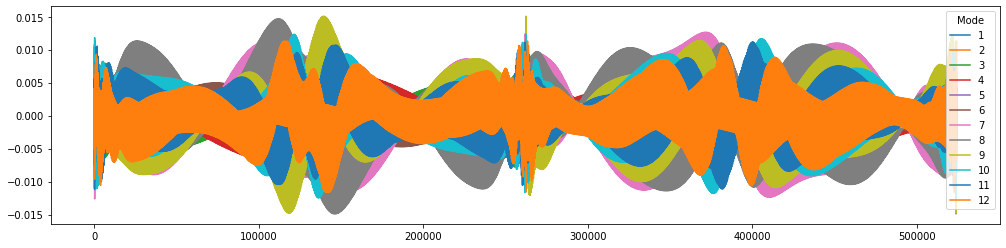

In [8]:
U_modes = U[:,:(r_99)]

plt.figure(figsize=(17,4))

for i in (range(r_99)):
    plt.plot(U_modes[:,i],label=i+1)
    
plt.legend(loc='upper right',title='Mode')
plt.grid
plt.show()

Now we reconstruct u and v keeping nly the selected modes

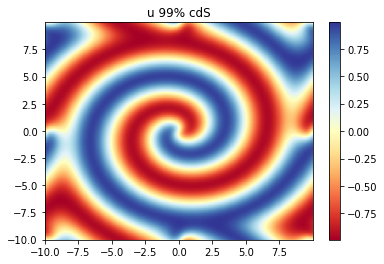

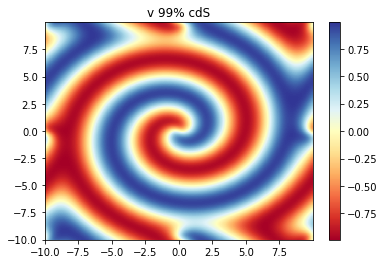

In [9]:
z_99_lin = U[:,:(r_99)] @ np.diag(S[:(r_99)]) @ VT[:(r_99),:]
u_99_lin = z_99_lin[0:u_lin.shape[0],:]
v_99_lin = z_99_lin[u_lin.shape[0]:,:]
u_99 = u_99_lin.reshape((np.shape(u)))
v_99 = v_99_lin.reshape((np.shape(v)))

#print(v_99.shape)

fig, ax = plt.subplots(1,1)
X, Y = np.meshgrid(x, y)
im = ax.pcolormesh(X, Y, u_99[:,:,-1], cmap='RdYlBu', rasterized=True)
fig.colorbar(im)
plt.title('u 99% cdS')
plt.show()
fig, ax = plt.subplots(1,1)
X, Y = np.meshgrid(x, y)
im = ax.pcolormesh(X, Y, v_99[:,:,-1], cmap='RdYlBu', rasterized=True)
fig.colorbar(im)
plt.title('v 99% cdS')
plt.show()

We calculate the relative error between the original values and the reconstructed ones and we evaluate a mean error for each time step

THe mean error is significantly below 0.1% for all the time steps

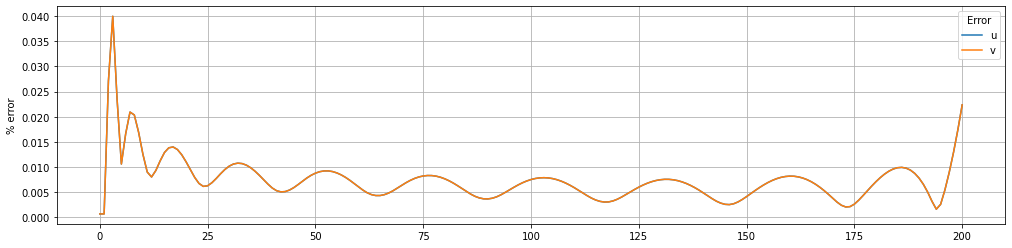

In [10]:
err_u = (u_99-u)/((np.max(u)-np.min(u))/2)
err_v = (v_99-v)/((np.max(v)-np.min(v))/2)
err_u_mean = np.mean(np.mean(np.abs(err_u),axis=0),axis=0)
err_v_mean = np.mean(np.mean(np.abs(err_v),axis=0),axis=0)

plt.figure(figsize=(17,4))
plt.plot(err_u_mean*100,label='u')
plt.plot(err_v_mean*100,label='v')
plt.grid()
plt.ylabel('% error')
plt.legend(loc='upper right',title='Error')
plt.show()

We project our vector z in the reduced space to build the NN

We keep all but the last timesteps for the input of the network

We keep from the second to the last timesteps for the output of the network

Data is scaled to facilitate training

In [11]:
z_r = np.matmul(np.transpose(z),U_modes)
print('Reduced order data has size', np.shape(z_r))
net_input = z_r[0:-1,:]
net_output = z_r[1:,:]

in_min = np.min(net_input)
in_max = np.max(net_input)

net_input_n = (net_input-in_min)/(in_max-in_min)
net_output_n = (net_output-in_min)/(in_max-in_min)
#print(np.shape(net_input))
#print(np.shape(net_output))

Reduced order data has size (201, 12)


A simple NN with 3 hidden layers is built

2022-07-14 07:30:54.400175: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "NN_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 12)]              0         
_________________________________________________________________
dense (Dense)                (None, 40)                520       
_________________________________________________________________
dense_1 (Dense)              (None, 40)                1640      
_________________________________________________________________
dense_2 (Dense)              (None, 40)                1640      
_________________________________________________________________
dense_3 (Dense)              (None, 12)                492       
Total params: 4,292
Trainable params: 4,292
Non-trainable params: 0
_________________________________________________________________


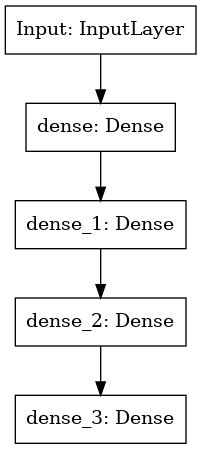

In [12]:
n_input = net_input.shape[1]
Input = tfk.Input(name = 'Input',shape=(n_input,))
layer_1 = tfkl.Dense(40, activation='relu', kernel_initializer='glorot_uniform')(Input)
layer_2 = tfkl.Dense(40, activation='relu', kernel_initializer='glorot_uniform')(layer_1)
layer_3 = tfkl.Dense(40, activation='relu', kernel_initializer='glorot_uniform')(layer_2)
Output = tfkl.Dense(n_input)(layer_3)
NN_1 = tfk.Model(inputs=Input, outputs=Output, name="NN_1")
NN_1.summary()
tfk.utils.plot_model(NN_1, "NN_1.png")

We define loss, metrics and callbacks to use during training

In [13]:
callbacks = [#tfk.callbacks.EarlyStopping(monitor = "val_loss",
              #             patience = 100,
              #             restore_best_weights = True),
    tfk.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                   factor = 0.5,
                                   patience = 100,
                                   min_lr = 1e-6)]
            
metrics = [tf.keras.metrics.MeanSquaredError(name="MSE", dtype=None),
          tf.keras.metrics.RootMeanSquaredError(name="RMSE", dtype=None),
          tf.keras.metrics.MeanAbsoluteError(name="mae", dtype=None)]
optimizer = tfk.optimizers.Adam(name="Adam")
loss = tfk.losses.MeanSquaredError()
#NN_1.compile(optimizer=optimizer,loss=loss,metrics = metrics)

In [14]:
epochs = 2000
batch_size = 5

NN training

In [15]:
NN_1.compile(optimizer=optimizer,loss=loss,metrics = metrics)
history=NN_1.fit(x=net_input_n,y=net_output_n,batch_size = batch_size,
        epochs = epochs, callbacks = callbacks,
        validation_split = 0.1).history

2022-07-14 07:30:56.080227: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/2000
36/36 [==============================] - 1s 8ms/step - loss: 0.1267 - MSE: 0.1267 - RMSE: 0.3559 - mae: 0.3055 - val_loss: 0.0159 - val_MSE: 0.0159 - val_RMSE: 0.1261 - val_mae: 0.1078
Epoch 2/2000
36/36 [==============================] - 0s 3ms/step - loss: 0.0150 - MSE: 0.0150 - RMSE: 0.1225 - mae: 0.0846 - val_loss: 0.0148 - val_MSE: 0.0148 - val_RMSE: 0.1217 - val_mae: 0.0823
Epoch 3/2000
36/36 [==============================] - 0s 3ms/step - loss: 0.0091 - MSE: 0.0091 - RMSE: 0.0955 - mae: 0.0698 - val_loss: 0.0103 - val_MSE: 0.0103 - val_RMSE: 0.1017 - val_mae: 0.0731
Epoch 4/2000
36/36 [==============================] - 0s 3ms/step - loss: 0.0065 - MSE: 0.0065 - RMSE: 0.0806 - mae: 0.0614 - val_loss: 0.0073 - val_MSE: 0.0073 - val_RMSE: 0.0855 - val_mae: 0.0650
Epoch 5/2000
36/36 [==============================] - 0s 3ms/step - loss: 0.0044 - MSE: 0.0044 - RMSE: 0.0664 - mae: 0.0508 - val_loss: 0.0053 - val_MSE: 0.0053 - val_RMSE: 0.0727 - val_mae: 0.0594
Epoch 6/20

In [16]:
#NN_1.save('net_l1.h5')

Plot training evolution

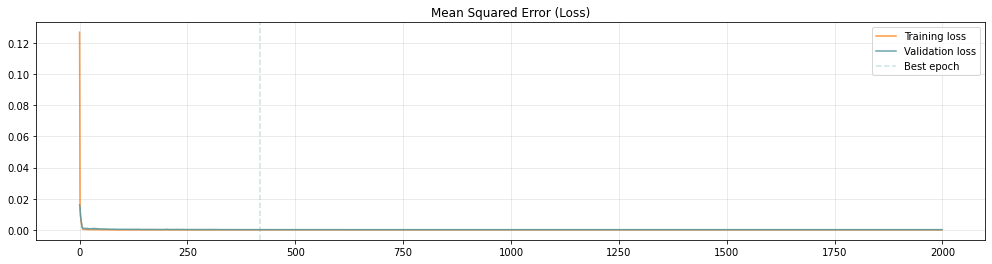

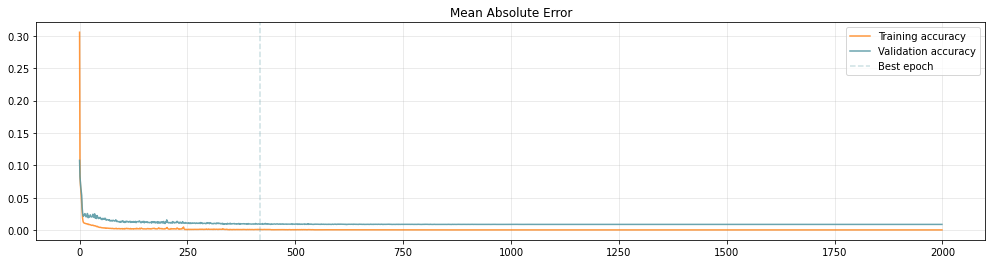

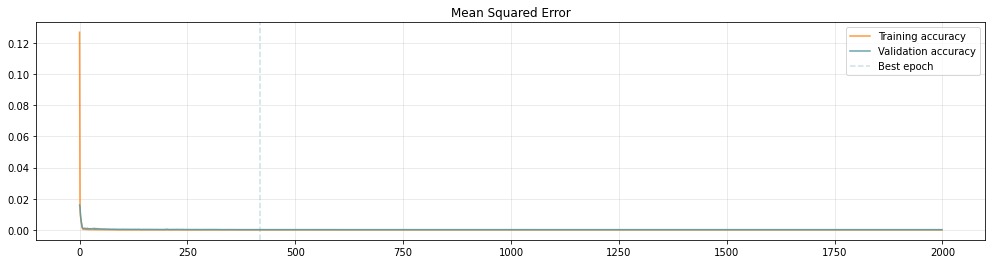

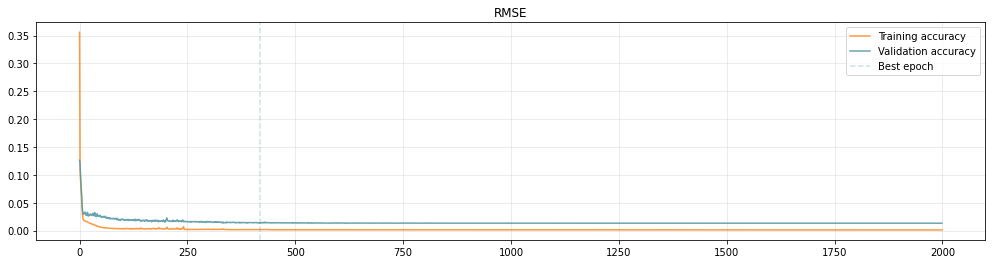

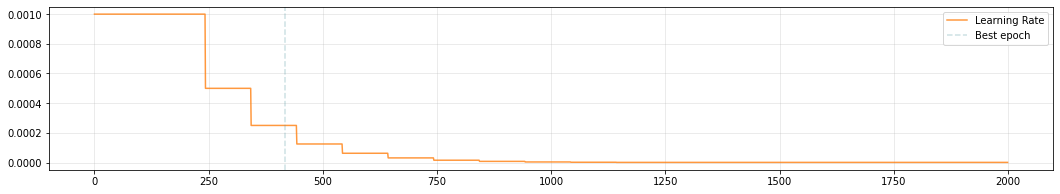

In [17]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error (Loss)')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['mae'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_mae'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Absolute Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['MSE'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_MSE'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['RMSE'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_RMSE'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('RMSE')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

Now we make predictions in the reduced subspace

In [18]:
net_pred = np.zeros([np.shape(net_input)[0]+1,np.shape(net_input)[1]])
net_pred[0,:] = net_input_n[0,:]
for i in range(np.shape(net_pred)[0]-1):
    i0 = net_pred[i,:]
    i0 = i0.reshape( (1,n_input) )
    net_pred[i+1,:] = NN_1.predict(i0)
    
net_pred = net_pred*(in_max-in_min)+in_min
#print(np.shape(net_pred))


Once we have the predictions we can go back to the original space of the dataset

To do so we multiply the network prediction times the pseudoinverse of the truncated mode matrix

In [19]:
z_pred_lin = np.transpose(net_pred @ np.linalg.pinv(U_modes))
#print(np.shape(z_pred_lin))
u_pred_lin = z_pred_lin[0:u_lin.shape[0],:]
v_pred_lin = z_pred_lin[u_lin.shape[0]:,:]
u_pred = u_pred_lin.reshape((np.shape(u)))
v_pred = v_pred_lin.reshape((np.shape(v)))
#print(np.shape(u_pred))

Here we plot the predicted values of u and v at the last timestep

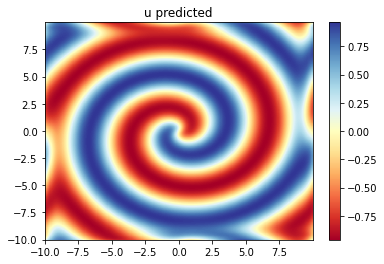

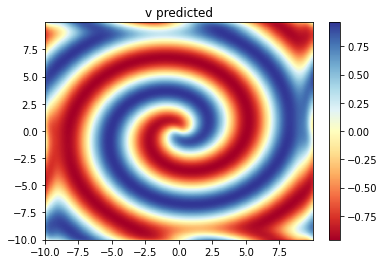

In [20]:
fig, ax = plt.subplots(1,1)
X, Y = np.meshgrid(x, y)
im = ax.pcolormesh(X, Y, u_pred[:,:,-1], cmap='RdYlBu', rasterized=True)
fig.colorbar(im)
plt.title('u predicted')
plt.show()
fig, ax = plt.subplots(1,1)
X, Y = np.meshgrid(x, y)
im = ax.pcolormesh(X, Y, v_pred[:,:,-1], cmap='RdYlBu', rasterized=True)
fig.colorbar(im)
plt.title('v predicted')
plt.show()

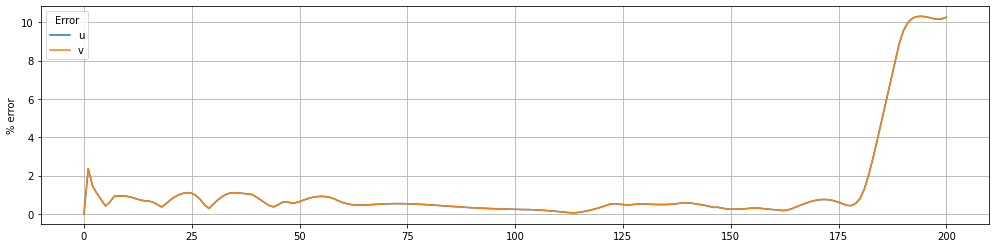

In [21]:
err_u_pred = (u_pred-u)/((np.max(u)-np.min(u))/2)
err_v_pred = (v_pred-v)/((np.max(v)-np.min(v))/2)
err_u_pred_mean = np.mean(np.mean(np.abs(err_u_pred),axis=0),axis=0)
err_v_pred_mean = np.mean(np.mean(np.abs(err_v_pred),axis=0),axis=0)

plt.figure(figsize=(17,4))
plt.plot(err_u_pred_mean*100,label='u')
plt.plot(err_v_pred_mean*100,label='v')
plt.grid()
plt.ylabel('% error')
plt.legend(loc='upper left',title='Error')
plt.show()

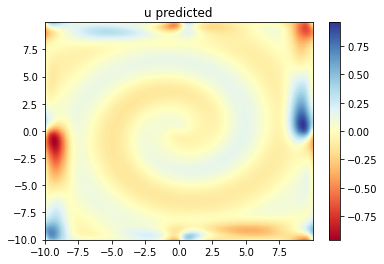

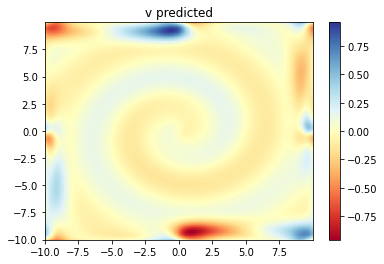

In [22]:
fig, ax = plt.subplots(1,1)
X, Y = np.meshgrid(x, y)
im = ax.pcolormesh(X, Y, u_pred[:,:,-1]-u[:,:,-1], cmap='RdYlBu', rasterized=True)
fig.colorbar(im)
plt.title('u predicted')
plt.show()
fig, ax = plt.subplots(1,1)
X, Y = np.meshgrid(x, y)
im = ax.pcolormesh(X, Y, v_pred[:,:,-1]-v[:,:,-1], cmap='RdYlBu', rasterized=True)
fig.colorbar(im)
plt.title('v predicted')
plt.show()